# Déploiement de la solution en local

In [ ]:
!pip install Pandas pillow tensorflow pyspark pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=0514a9b3629ae69334bfbe847ffcf74d69fee09fd5283f947ef706f1dcd6cc5f
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


## Import des librairies

In [ ]:
import pandas as pd
from PIL import Image
import numpy as np
import io
import os

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession

## Définition des PATH pour charger les images <br /> et enregistrer les résultats

In [ ]:
PATH = os.getcwd()
PATH_Data = PATH+'/data/Test1'
PATH_Result = PATH+'/data/Results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

PATH:        /content
PATH_Data:   /content/data/Test1
PATH_Result: /content/data/Results


## Création de la SparkSession

In [ ]:
spark = (SparkSession
             .builder
             .appName('P8')
             .master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate()
)

<u>Nous créons également la variable "**sc**" qui est un **SparkContext** issue de la variable **spark**</u> :

In [ ]:
sc = spark.sparkContext

<u>Affichage des informations de Spark en cours d'execution</u> :

In [ ]:
spark

## Traitement des données

### Chargement des données

In [ ]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

<u>Affichage des 5 premières images contenant</u> :
 - le path de l'image
 - la date et heure de sa dernière modification
 - sa longueur
 - son contenu encodé en valeur hexadécimal

<u>Je ne conserve que le **path** de l'image et j'ajoute <br />
    une colonne contenant les **labels** de chaque image</u> :

In [ ]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+-----------------------------------+-----+
|path                               |label|
+-----------------------------------+-----+
|file:/content/data/Test1/3_100.jpg |Test1|
|file:/content/data/Test1/4_100.jpg |Test1|
|file:/content/data/Test1/8_100.jpg |Test1|
|file:/content/data/Test1/46_100.jpg|Test1|
|file:/content/data/Test1/7_100.jpg |Test1|
+-----------------------------------+-----+
only showing top 5 rows

None


###  Préparation du modèle

In [ ]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

14536120/14536120 [==============================] - 0s 0us/step


In [ ]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

Affichage du résumé de notre nouveau modèle où nous constatons <br />
que <u>nous récupérons bien en sortie un vecteur de dimension (1, 1, 1280)</u> :

In [ ]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

Tous les workeurs doivent pouvoir accéder au modèle ainsi qu'à ses poids. <br />
Une bonne pratique consiste à charger le modèle sur le driver puis à diffuser <br />
ensuite les poids aux différents workeurs.

In [ ]:
brodcast_weights = sc.broadcast(new_model.get_weights())

<u>Mettons cela sous forme de fonction</u> :

In [ ]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

### Définition du processus de chargement des images et application <br/>de leur featurisation à travers l'utilisation de pandas UDF

Ce notebook définit la logique par étapes, jusqu'à Pandas UDF.

<u>L'empilement des appels est la suivante</u> :

- Pandas UDF
  - featuriser une série d'images pd.Series
   - prétraiter une image

In [ ]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/functions.py:407: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


### Exécution des actions d'extraction de features

In [ ]:
# spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [ ]:
features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

<u>Rappel du PATH où seront inscrits les fichiers au format "**parquet**" <br />
contenant nos résultats, à savoir, un DataFrame contenant 3 colonnes</u> :
 1. Path des images
 2. Label de l'image
 3. Vecteur de caractéristiques de l'image

In [ ]:
print(PATH_Result)

/content/data/Results


<u>Enregistrement des données traitées au format "**parquet**"</u> :

In [ ]:
features_df.write.mode("overwrite").parquet(PATH_Result)

## Chargement des données enregistrées et validation du résultat

<u>On charge les données fraichement enregistrées dans un **DataFrame Pandas**</u> :

In [ ]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')

<u>On affiche les 5 premières lignes du DataFrame</u> :

In [ ]:
df.head()

,path,label,features
0,file:/content/data/Test1/43_100.jpg,Test1,"[0.9958219, 0.09498338, 0.0, 0.0, 0.0, 0.59119..."
1,file:/content/data/Test1/5_100.jpg,Test1,"[0.8150559, 0.007707878, 0.0, 0.0, 0.0, 0.7270..."
2,file:/content/data/Test1/40_100.jpg,Test1,"[0.7846502, 0.055052727, 0.0, 0.0, 0.0, 0.7817..."
3,file:/content/data/Test1/41_100.jpg,Test1,"[0.80328274, 0.07817287, 0.0, 0.0, 0.0, 0.7249..."
4,file:/content/data/Test1/44_100.jpg,Test1,"[0.9480304, 0.031405304, 0.0, 0.0, 0.003041471..."


<u>On valide que la dimension du vecteur de caractéristiques des images est bien de dimension 1280</u> :

In [ ]:
df.loc[0,'features'].shape

(1280,)

## Réduction de dimensions avec PCA

In [ ]:
from pyspark.sql.functions import element_at, split, col, pandas_udf, PandasUDFType, udf
from pyspark.ml.feature import PCA
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

In [ ]:

def preprocess_pca(dataframe):
  '''
     Préparation des données :
     - transformation en vecteur dense
     - standardisation
     param : dataframe : dataframe d'images
     return : dataframe avec features vecteur dense standardisé
  '''

  # Préparation des données - conversion des données images en vecteur dense
  transform_vecteur_dense = udf(lambda r: Vectors.dense(r), VectorUDT())
  dataframe = dataframe.withColumn('features_vectors', transform_vecteur_dense('features'))

  # Standardisation obligatoire pour PCA
  scaler_std = StandardScaler(inputCol="features_vectors", outputCol="features_scaled", withStd=True, withMean=True)
  model_std = scaler_std.fit(dataframe)
  # Mise à l'échelle
  dataframe = model_std.transform(dataframe)

  return dataframe



# Recherche du nombre de composante expliquant 95% de la variance



def recherche_nb_composante(dataframe, nb_comp=400):
    '''
       Recherche d nombre de composante expliquant 95% de la variance
       param : dataframe : dataframe d'images
       return : k nombre de composante expliquant 95% de la variance totale
    '''

    pca = PCA(k = nb_comp,
              inputCol="features_scaled",
              outputCol="features_pca")

    model_pca = pca.fit(dataframe)
    variance = model_pca.explainedVariance
    plt.plot(np.arange(len(variance)) + 1, variance.cumsum(), c="red", marker='o')
    plt.xlabel("Nb composantes")
    plt.ylabel("% variance")
    plt.show(block=False)

    def nb_comp ():
      for i in range(len(variance)):
          a = variance.cumsum()[i]
          if a >= 0.95:
              print("{} composantes principales expliquent au moins 95% de la variance totale".format(i))
              break
      return i

    k=nb_comp()

    return k



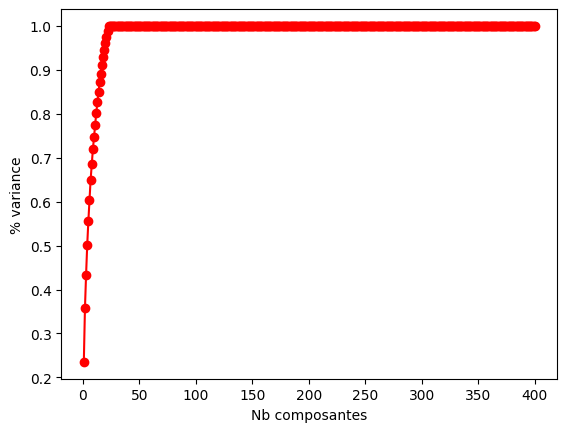

19 composantes principales expliquent au moins 95% de la variance totale
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|                path|label|            features|    features_vectors|     features_scaled|         vectors_pca|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|file:/content/dat...|Test1|[0.9958219, 0.094...|[0.99582189321517...|[1.80463993488163...|[-14.172223681857...|
|file:/content/dat...|Test1|[0.8150559, 0.007...|[0.81505590677261...|[0.11238220223625...|[24.3312349446141...|
|file:/content/dat...|Test1|[0.7846502, 0.055...|[0.78465020656585...|[-0.1722636114148...|[-8.6621640118564...|
|file:/content/dat...|Test1|[0.80328274, 0.07...|[0.80328273773193...|[0.00216657628296...|[-13.643489946741...|
|file:/content/dat...|Test1|[0.9480304, 0.031...|[0.94803041219711...|[1.35723550388768...|[-11.344624525250...|
|file:/content/dat...|T

In [ ]:

# Pré-processing (vecteur dense, standardisation)
df_pca = preprocess_pca(features_df)

# Nombre de composante expliquant 95% de la variance
n_components = recherche_nb_composante(df_pca)



# Réduction de dimension PCA



# Entrainement de l'algorithme
pca = PCA(k=n_components, inputCol='features_scaled', outputCol='vectors_pca')
model_pca = pca.fit(df_pca)



# Transformation des images sur les k premières composantes
df_reduit = model_pca.transform(df_pca)


# Visualisation du dataframe réduit
df_reduit.show(20)